In [2]:
!pip install tensorflow
from tensorflow import keras

import tensorflow as tf
import random as python_random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.33.0
    Uninstalling google-auth-1.33.0:
      Successfully uninstalled google-auth-1.33.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.2 which is incompatible.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.23.4 which is incompatible.
google-cloud-core 1.7.1 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.23.4 which is incompatible.
google-api-core 1.25.1 requires google-auth<2.0dev,>=1.21.1, but you have google-auth 2.23.4 which is incompatible.
C:\Users\grego\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_min

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

# Homework 3 - Neural Network for Classification
## Overview
* Binary Classification
* Hyperparameter tuning
* Multi-Class Classification

In the hands-on session we already gained some experience with neural network for regression. In this homework we will focus on classification problem instead, and will practice with hyperparameter tuning. The dataset is the granta data we have used in Hands-on 7 for KNN, SVM and decision tree. We will predict materials' tolerance to oxidation at 500C based on their Young's modulus and melting point.

## Classification vs Regression: different settings in neural network
Typical Regression NN architecture:

| Hyperparameter | Typical Value |
|----------------|---------------|
| # input neurons | One per input feature |
| # hidden layers | Depends on the problem |
| # neurons per hidden layer | Depends on the problem |
| # output neurons | 1 per prediction dimension |
| Hidden activation | ReLU (or SELU) |
| Output activation | None or ReLU/Softplus (if positive outputs) or Sigmoid/Tanh (if bounded outputs) |
| Loss function | MSE or MAE/Huber (if outliers) |

Typical Classification NN architecture:

| Hyperparameter | Binary Classification | MuiltiClass Classification |
|--------------|-------------|--------------|
| Input and hidden layers | Same as regression | Same as regression |
| # output neurons | 1 | 1 per class |
| Output layer activation | Sigmoid | Softmax|
| Loss function | Binary Cross Entropy | Sparse Categorical Crossentropy or Categorical Crossentropy|

Note: the muilticlass classification here and later in this notebook assumes each class is exclusive (each sample only belongs to one of the classes)

Reference: 

Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow Concepts, Tools, and Techniques to Build Intelligent Systems by Aurélien Géron

Loss functions in Keras: https://keras.io/api/losses/

## Binary Classification

Same as what we did in the SVM part in hands-on 7, we combine the 'Acceptable', 'Limited use', 'Unacceptable' into one new category called 'Other', to convert this classification problem into a binary one.

In [86]:
# you should download the grantadata.p from canvas first
granta = pickle.load(open('grantadata.p','rb'))

In [87]:
x = granta[["Young's modulus (10^6 psi)",'Melting point (°F)']].values
y = granta['Oxidation at 500C'].copy()

for i in range(len(granta)):
    if granta['Oxidation at 500C'][i] in ['Acceptable', 'Limited use', 'Unacceptable']:
        y[i] = 'Other'

Labels should be converted to numerical values for the neural network to proceed. Here we convert the label 'Excellent' to 0 and 'Other' to 1.

In [88]:
labels_map = {'Excellent':0,'Other':1}
y_int = y.map(labels_map)
y_int

name
  Zirconium carbide                                        0
  Zirconia with magnesia foam (partly stabilized)(0.81)    0
  Zirconia with calcia foam (fully stabilized)(0.74)       0
  Zirconia mullite alumina foam (0.63)                     0
  Zirconia foam (partly stabilized)(1.28)                  0
                                                          ..
  Boron nitride (HIP)                                      0
  Carbon (anthracite coal base)                            1
  Concrete (conducting)                                    0
  Concrete (high alumina cement)                           0
Al-47%SiC(f), longitudinal                                 1
Name: Oxidation at 500C, Length: 390, dtype: int64

Train-test split, and normalize.

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x, y_int,
                                                    test_size=0.20,
                                                    random_state=111)

scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

Construct the neural network.


In [90]:
def binary_nn():
    model = Sequential()
    #here we make an explicit input layer, it simply passes the input data to the later layer
    model.add(Input(shape=x_train_norm.shape[1]))
    #hidden layers
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    #output layer
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

### Question 1: Note that here we set the parameter `metrics` in model.compile to be `accuracy`. What does it mean? 
(you can refer to keras documentation about metrics here: https://keras.io/api/metrics/ )


Accuracy represents the accuracy of the prediction of the class.

Train the neural network.

In [91]:
classifier = KerasClassifier(build_fn=binary_nn)
history = classifier.fit(x_train_norm, y_train, validation_split=0.33, epochs=1000, batch_size=32,verbose=0)

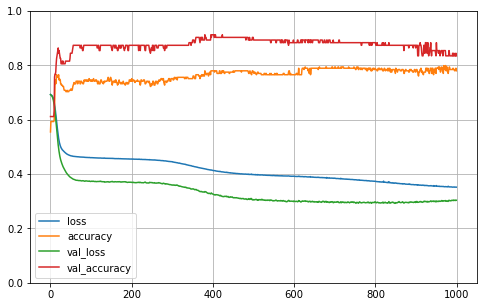

In [92]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Make prediction on test set, and get test accuracy.

In [93]:
y_test_predict = classifier.predict(x_test_norm)

In [94]:
test_loss = classifier.model.evaluate(x_test_norm, y_test)
print("test set accuracy is %.2f" % test_loss[1])

78/78 [==============================] - 0s 77us/sample - loss: 0.3709 - accuracy: 0.8333
test set accuracy is 0.83



Note that the output value of this neural network is one single value ranges from 0 to 1. This value is actually inferrd as the probability that a sample belong to the class 1 (corresponding to the label 'Other' in our case).
The samples with probability greater than 0.5 will be classified to class 1, and the samples with probablity equal or lower than 0.5 will be classified to class 0.

A decision boundary can thus be found. The code below creates a meshgrid first(a matrix with evenly spaced x and y value), and apply the classifer we just trained to each point in the meshgrid. The points that classified to class 1 are shown in red and the points that classified to class 0 are shown in blue. Thus the boundary in between the red and blue regions is shown as the decision boundary.

### To-do 1: Please make a scatterplot superposed on the given decision boundary plot. In the scatterplot show the training data points as circles with color indicating its true category, show the testing data points as crosses with color indicating its predicted category.
(You can refer to the scatterplot in the SVM part of Hands-on 7, though you don't have to use the same way to produce the plot)


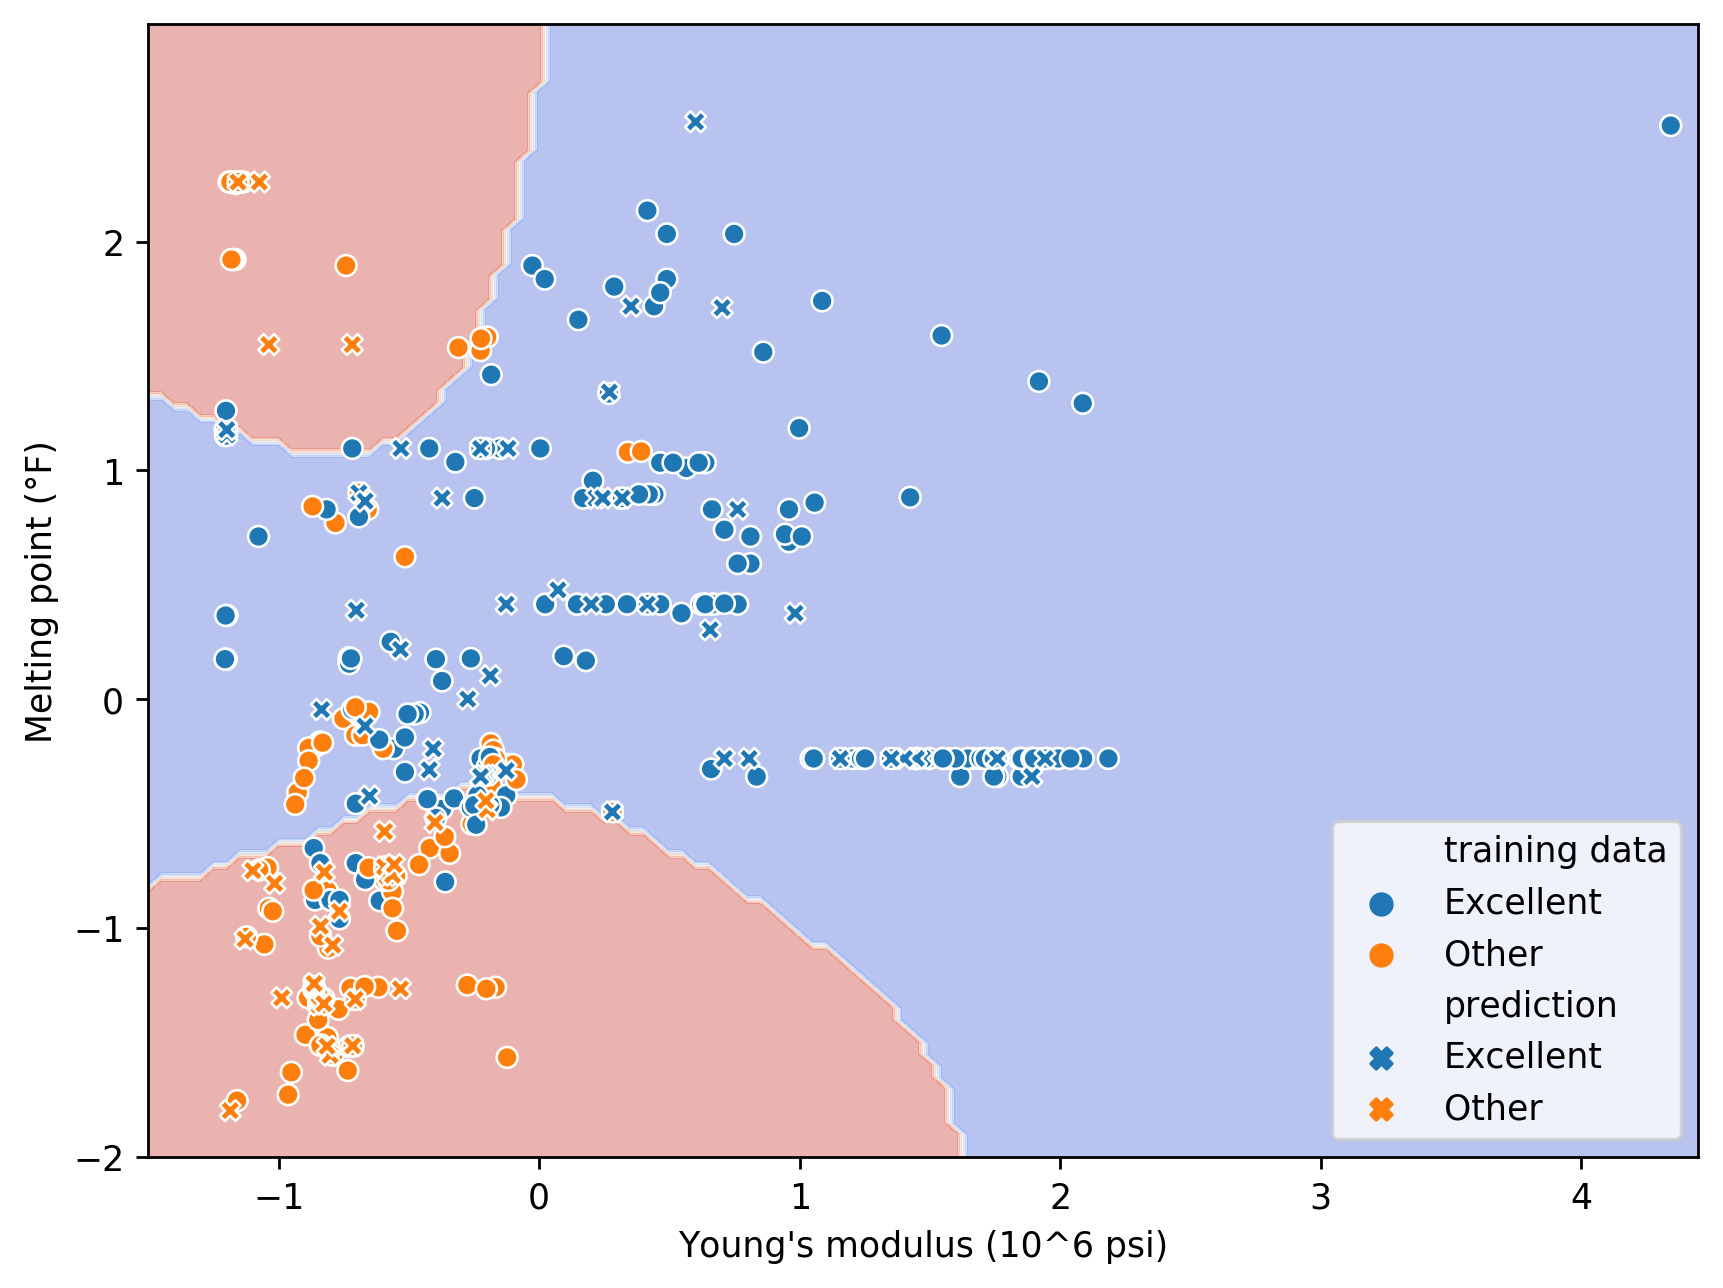

In [95]:
# create a dense meshgrid
xx, yy = np.meshgrid(np.arange(-1.5, 4.5, 0.05),
                     np.arange(-2, 3, 0.05))

# classify each points in the grid
z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]) 
z = np.around(z)
z = z.reshape(xx.shape)

#plot the meshgrid
plt.figure(figsize=(8,6),dpi=250)
plt.contourf(xx, yy, z, cmap=plt.cm.coolwarm, alpha=0.4)

# please add your code here to create the scatter plot


train = pd.DataFrame(x_train_norm, columns = ["Young's modulus (10^6 psi)",'Melting point (°F)'])
train['training data'] = y_train.values
colors = {0: 'Excellent', 1: 'Other'}
train['training data'] = train['training data'].map(colors)

predict = pd.DataFrame(x_test_norm, columns = ["Young's modulus (10^6 psi)","Melting point (°F)"])
predict['prediction'] = y_test_predict
predict['prediction'] = predict['prediction'].map(colors)

sns.scatterplot("Young's modulus (10^6 psi)",'Melting point (°F)', data=train,
                hue_order=['Excellent','Other'], hue='training data')

sns.scatterplot("Young's modulus (10^6 psi)", 'Melting point (°F)', data=predict,
                markers = ['X']*2, hue_order=['Excellent','Other'], 
                hue='prediction', style='prediction')
               

## Hyperparameter Tuning

Instead of trying different setting one by one like what we did in the hands-on session, we can use the function `RandomizedSearchCV` in sklearn to randomly search different combination of hyperparameters, and find the one with highest test accuracy estimated by k-fold cross validation.

Wrap the neural network in a function first. Note that the hyperparameters you would like to tune inside the neural network should be set as the parameters of this wrapping function.

In [96]:
def binary_nn_builder(optimizer='Adam',learning_rate=0.01):
    model = Sequential()
    model.add(Input(shape=x_train_norm.shape[1]))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

In [97]:
classifier_search = KerasClassifier(binary_nn_builder)

The parameter `param_distributions` should be a dictionary that gives the searching range for each hyperparameters. 

As an example, we search: optimizers in Adam or SGD, the batch size from 4 to 64, the learning rate from 0.0001 to 0.1.

The parameter `cv` specifies the number of folds in k-fold cross validation.
`n_iter` specifies the number of parameter settings that are sampled.

Note that the `epochs` here means all the hyperparameters are evaluated after 100 epochs of training. Feel free to set it to a larger number (but will take longer).

In [119]:
parameters = {
    "optimizer": ['Adam','SGD'],
    "batch_size": np.arange(4,65).tolist(),
    "learning_rate":(0.1,0.03,0.01,0.003,0.001,0.0003,0.0001)
}

rnd_search_cv = RandomizedSearchCV(classifier_search,param_distributions=parameters,n_iter=20,cv=3,verbose=0,n_jobs=-1)
rnd_search_cv.fit(x_train_norm, y_train,verbose=0,epochs=100)

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f40fc765a50>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'batch_size': [4, 5, 6, 7, 8, 9, 10, 11,
                                                       12, 13, 14, 15, 16, 17,
                                                       18, 19, 20, 21, 22, 23,
                                                       24, 25, 26, 27, 28, 29,
                                                       30, 31, 32, 33, ...],
                                        'learning_rate': (0.1, 0.03, 0.01,
                                                          0.003, 0.001, 0.0003,
                                                          0.0001),
                                        'optimizer': ['Adam', 'SGD']})

Return the hyperparameters that gave the best test accuracy estimated by k-fold cross validation.

In [144]:
rnd_search_cv.best_params_

{'optimizer': 'SGD', 'learning_rate': 0.1, 'batch_size': 37}

Return the model that gave the best test accuracy estimated by k-fold cross validation.

In [100]:
optimal_model = rnd_search_cv.best_estimator_.model

Evaluate the best model on test dataset.

In [101]:
test_loss_optimal = optimal_model.evaluate(x_test_norm, y_test)
print("test set error is %.2f" % test_loss_optimal[0])

78/78 [==============================] - 0s 1ms/sample - loss: 0.3896 - accuracy: 0.7821
test set error is 0.39


### To-do 2: Set the optimizer,batch size,learning rate to be the optimal one we found above, then search: the number of neuron in hidden layer from 4 to 20, activation function of hidden layer in relu or tanh. Feel free to use larger `epoch` and `n_iter` that are affordable to you.

In [160]:
def binary_nn_builder2(numberNeurons1, numberNeurons2, activation1, activation2, optimizer,learning_rate):
    model = Sequential()
    #input layer
    model.add(Input(shape=x_train_norm.shape[1]))
    #hidden layer 1
    model.add(Dense(numberNeurons1, kernel_initializer='normal', activation=activation1))
    #hidden layer 2 
    model.add(Dense(numberNeurons2, kernel_initializer='normal', activation=activation2))
    #output layer
    model.add(Dense(1,kernel_initializer='normal', activation = 'sigmoid'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

In [161]:
classifier_search = KerasClassifier(binary_nn_builder2)

parameters = {
    "numberNeurons1": np.arange(4,21).tolist(),
    "numberNeurons2": np.arange(4,21).tolist(),
    "activation1": ['relu','tanh'],
    "activation2": ['relu','tanh'],
    "optimizer": ['SGD'],
    "learning_rate": [0.1],
    "batch_size": [37]
}

rnd_search_cv = RandomizedSearchCV(classifier_search,
                                   param_distributions=parameters,
                                   n_iter=20,cv=3,verbose=0,n_jobs=-1)
rnd_search_cv.fit(x_train_norm, y_train,verbose=0,epochs=100)


RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4104465d10>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'activation1': ['relu', 'tanh'],
                                        'activation2': ['relu', 'tanh'],
                                        'batch_size': [37],
                                        'learning_rate': [0.1],
                                        'numberNeurons1': [4, 5, 6, 7, 8, 9, 10,
                                                           11, 12, 13, 14, 15,
                                                           16, 17, 18, 19, 20],
                                        'numberNeurons2': [4, 5, 6, 7, 8, 9, 10,
                                                           11, 12, 13, 14, 15,
                                                           16, 17, 18, 19, 20],
                                        'optimizer': ['SGD']})

In [163]:
print(rnd_search_cv.best_params_)
optimal_model = rnd_search_cv.best_estimator_.model
test_loss_optimal = optimal_model.evaluate(x_test_norm, y_test)
print("test set error is %.2f" % test_loss_optimal[0])

{'optimizer': 'SGD', 'numberNeurons2': 12, 'numberNeurons1': 15, 'learning_rate': 0.1, 'batch_size': 37, 'activation2': 'tanh', 'activation1': 'relu'}
78/78 [==============================] - 0s 1ms/sample - loss: 1.0990 - accuracy: 0.4487
test set error is 1.10


## Multiclass classification

For multiclass classification problem, the number of output neurons should equal to the number of classes. Each output value will be a number between 0 and 1, which you can interpret as the estimated probability of the corresponding class. You should use the `Softmax` activation function in the output layer to ensure all the estimated probability add up to one.

You can either convert the labels to integers by the `LabelEncoder` from sklearn, or convert to the one-hot numeric array by the `LabelBinarizer` from sklearn.

Note that your loss functions should be adjusted accordingly. Sparse Categorical Crossentropy should be used for label encoded case and Categorical Crossentropy should be used for one-hot encoded case.

In [114]:
# Label Encoder as example
le = LabelEncoder()
le.fit(granta['Oxidation at 500C'].values)
list(le.classes_)

['Acceptable', 'Excellent', 'Limited use', 'Unacceptable']

In [109]:
y_encode = le.transform(granta['Oxidation at 500C'].values)

In [110]:
y_encode

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 3, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 1, 1,
       1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3,

In [111]:
# One-hot encode as example
lb = LabelBinarizer()
lb.fit(granta['Oxidation at 500C'].values)
list(lb.classes_)

['Acceptable', 'Excellent', 'Limited use', 'Unacceptable']

In [112]:
y_onehot = lb.transform(granta['Oxidation at 500C'].values)

In [113]:
y_onehot

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1]])

### To-do 3: Create a multiclass classifer with two hidden layers (all the hyperparameters are up to your choice). Train your neural network(hyperparameter tuning is not required), plot the `history`. Get the test accuracy.

Note: make sure you correctly set up number of neurons and activation funciton in the output layer. make sure you use appropriate loss function.

In [124]:
#I Will be Using Y_Encode
le = LabelEncoder()
le.fit(granta['Oxidation at 500C'].values)

#Train Test Splitting of the Y_Encode
x_train, x_test, y_trian, y_test, = train_test_split(x,y_encode,test_size = 0.20, random_state = 245)


def multiclass_nn():
    model = Sequential()
    #here we make an explicit input layer, it simply passes the input data to the later layer
    model.add(Input(shape=x_train_norm.shape[1]))
    #hidden layers
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(8, kernel_initializer='normal', activation='tanh'))
    #output layer
    model.add(Dense(4, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

#Normalize
scaler = StandardScaler().fit(x_train)
x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)

classifier = KerasClassifier(multiclass_nn)
history = classifier.fit(x_train_normalized,y_train, validation_split = 0.33, epochs = 100, batch_size = 32, verbose = 0)

In [134]:
#history.history

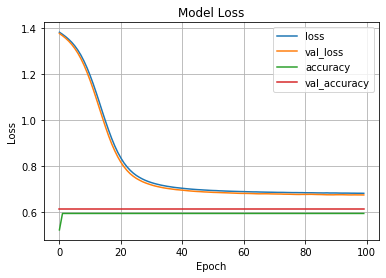

In [141]:
plt.plot(range(100),history.history['loss'], label = 'loss')
plt.plot(range(100),history.history['val_loss'], label = 'val_loss')
plt.plot(range(100),history.history['accuracy'], label = 'accuracy')
plt.plot(range(100),history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [135]:
print("Final MSE for Train is %.2f and for Validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

Final MSE for Train is 0.68 and for Validation is 0.67
